In [1]:
import os
os.chdir('../..')
!ls

product_impacts


In [2]:
import os.path
import pandas as pd
from skimpy import skim
import requests
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, mean_squared_error, r2_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from hiclass import LocalClassifierPerParentNode, LocalClassifierPerLevel

from product_impacts.product_cat.run_model import get_store, get_ndns_cats, get_products, get_ndns_matches, get_tsne

import numpy as np
import pickle
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

sns.set()

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.environ["RAY_ENABLE_MAC_LARGE_OBJECT_STORE"] = "1"

In [5]:
ndns = get_ndns_cats('../../future_of_food/NDNS UK/ndns_edited.csv')
products = get_products('../../future_of_food/foodDB_23June/products.csv')
labelled_data, non_food_products = get_ndns_matches(
    ndns, products)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
# removing duplicated product names + ingredients (basically products with same exact feature vectors)
labelled_data['product_list_name_lower'] = labelled_data['product_list_name'].str.lower()
labelled_data['ingredients_text_lower'] = labelled_data['ingredients_text'].str.lower()
labelled_data = labelled_data.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [7]:
# lev 0 predictions
predicted_data = pd.read_csv('../../future_of_food/NDNS UK/predictions/predictions_lev0_manuallabels_nonHI_RF_withcorrections_14Oct2024.csv')

In [8]:
predicted_data.shape

(262711, 11)

In [9]:
predicted_data['parentcategory_pred'].value_counts()

Cereals and Cereal Products             52426
Miscellaneous                           27598
Meat and Meat Products                  26837
Non-Alcoholic Beverages                 25994
Sugar, Preserves and Confectionery      25822
Vegetables, Potatoes                    23757
Milk and Milk Products                  23239
Alcoholic Beverages                     15150
Fish and Fish Dishes                     9302
Fruit                                    7343
Savoury Snacks                           6453
Not Food                                 5086
Nuts and Seeds                           5057
Fat Spreads                              3811
Commercial Toddlers Foods and Drinks     2488
Eggs and Egg Dishes                      1315
Dietary Supplements                       622
Artificial Sweeteners                     404
Savoury Snack                               7
Name: parentcategory_pred, dtype: int64

In [10]:
pred = predicted_data[predicted_data['parentcategory_pred']=='Sugar, Preserves and Confectionery'].reset_index(drop=True)
lab = labelled_data[(labelled_data['parentcategory']=='Sugar, Preserves and Confectionery')
                           & (labelled_data['subfoodgroupdesc'].notnull())].reset_index(drop=True)
lab = lab.merge(pred[['product_id']])

In [11]:
pred.shape

(25822, 11)

In [12]:
lab.shape

(5914, 12)

In [13]:
lab['subfoodgroupdesc'].value_counts()

Chocolate confectionery             3442
Sugar confectionery                 1206
Preserves                            691
Sweet spreads fillings and icing     340
Sugar                                235
Name: subfoodgroupdesc, dtype: int64

In [14]:
lab['mainfoodgroupdesc'].value_counts()

Chocolate confectionery                3442
Sugars, preserves and sweet spreads    1266
Sugar confectionery                    1206
Name: mainfoodgroupdesc, dtype: int64

In [15]:
pred['subfoodgroup_lab'].value_counts()

Chocolate confectionery                        3441
Sugar confectionery                            1195
Preserves                                       681
Sweet spreads fillings and icing                340
Other cereal based puddings                     237
Sugar                                           235
Biscuits                                         68
Crisps and savoury snacks                        10
Ice cream                                         9
Soft drinks not low calorie carbonated            8
Savoury sauces pickles gravies & condiments       8
Non-nutrient supplements (including herbal)       8
Artificial sweeteners                             7
Cereal based milk puddings                        6
Beverages dry weight                              6
Other fruit not canned                            6
Buns cakes and pastries                           5
Sponge puddings                                   5
Fromage frais and other dairy desserts            4
Smoothies   

In [16]:
lev2_labels_add = pred[[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store']]
lev2_labels_add['parentcategory'] = 'Sugar, Preserves and Confectionery'
lev2_labels_add['subfoodgroupdesc'] = np.NaN


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mandarins in orange jelly")),
                    'subfoodgroupdesc'] = 'Preserves'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ginger preserve")),
                    'subfoodgroupdesc'] = 'Preserves'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("strawberry jelly pot")),
                    'subfoodgroupdesc'] = 'Preserves'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("hartleys"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("jelly")),
                    'subfoodgroupdesc'] = 'Preserves'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("easy squeezy jelly")),
                    'subfoodgroupdesc'] = 'Preserves'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fruit filling")),
                    'subfoodgroupdesc'] = 'Sweet spreads fillings and icing'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("biscoff spread")),
                    'subfoodgroupdesc'] = 'Sweet spreads fillings and icing'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("caramel sauce")),
                    'subfoodgroupdesc'] = 'Sweet spreads fillings and icing'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("marshmallows coated")),
                    'subfoodgroupdesc'] = 'Chocolate confectionery'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("nomo free from")),
                    'subfoodgroupdesc'] = 'Chocolate confectionery'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("black pearls")),
                    'subfoodgroupdesc'] = 'Chocolate confectionery'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("orange lollies")),
                    'subfoodgroupdesc'] = 'Sugar confectionery'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vanilla dessert")),
                    'subfoodgroupdesc'] = 'Sugar confectionery'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bon bons")),
                    'subfoodgroupdesc'] = 'Sugar confectionery'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("caramel dessert")),
                    'subfoodgroupdesc'] = 'Sugar confectionery'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("gold stars")),
                    'subfoodgroupdesc'] = 'Sugar confectionery'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("angel delight butterscotch")),
                    'subfoodgroupdesc'] = 'Sugar confectionery'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cake bars carrot")),
                    'subfoodgroupdesc'] = 'Sugar confectionery'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("jam sugar")),
                    'subfoodgroupdesc'] = 'Sugar'

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A val

In [17]:
# lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cake bars carrot"))
#                    ]

In [18]:
lev2_labels_add = lev2_labels_add.merge(
    ndns.drop('detaileddesc', axis=1)).drop_duplicates(subset=['product_id', 'subfoodgroupdesc'])
lev2_labels_add['product_list_name_lower'] = lev2_labels_add['product_list_name'].str.lower()
lev2_labels_add['ingredients_text_lower'] = lev2_labels_add['ingredients_text'].str.lower()
lev2_labels_add = lev2_labels_add.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

dups = lab[['product_id', 'product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']].merge(
    lev2_labels_add[['product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']])['product_id'].values
lev2_labels_add = lev2_labels_add[(~lev2_labels_add['product_id'].isin(dups))]
lab = lab[(~lab['product_id'].isin(lev2_labels_add['product_id'].values))]
lab = pd.concat([lab, lev2_labels_add], ignore_index=True, axis=0).drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [19]:
lab.shape

(6141, 12)

In [20]:
lab['subfoodgroupdesc'].value_counts()

Chocolate confectionery             3456
Sugar confectionery                 1248
Preserves                            819
Sweet spreads fillings and icing     375
Sugar                                243
Name: subfoodgroupdesc, dtype: int64

In [21]:
pred = pred.drop('mainfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'mainfoodgroupdesc']], how='left').rename(columns={'mainfoodgroupdesc': 'mainfoodgroup_lab'})

pred = pred.drop('subfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'subfoodgroupdesc']], how='left').rename(columns={'subfoodgroupdesc': 'subfoodgroup_lab'})

In [22]:
query_embeddings = np.load('../../future_of_food/bert/all_embeddings_all3.npy')
tsne_results = get_tsne(query_embeddings, '../../future_of_food/bert/tsne_results_all3.npy')
product_ids = np.load('../../future_of_food/bert/all_ids_all3.npy')

features = pd.DataFrame(data=query_embeddings)
id_col = 'product_id'
X_cols = features.columns.tolist()
y_cols = ['parentcategory', 'mainfoodgroupdesc', 'subfoodgroupdesc']

features['product_id'] = pd.Series(product_ids, index=features.index)
features[['tsne_0', 'tsne_1']] = tsne_results
lab = lab.merge(features)

In [23]:
for i in range(1):
    train, test = train_test_split(lab, test_size=0.1, random_state=i)
    print(f'Number of unique level 1 categories in train: {train[y_cols[1]].nunique()}')
    print(f'Number of unique level 1 categories in test: {test[y_cols[1]].nunique()}')
    print(f'Number of unique level 2 categories in train: {train[y_cols[2]].nunique()}')
    print(f'Number of unique level 2 categories in test: {test[y_cols[2]].nunique()}\n')

    X_train = train[X_cols]
    y_train = train[[y_cols[1], y_cols[2]]]
    y_train1 = train[y_cols[1]]
    y_train2 = train[y_cols[2]]

    X_test = test[X_cols]
    y_test = test[[y_cols[1], y_cols[2]]]
    y_test1 = test[y_cols[1]]
    y_test2 = test[y_cols[2]]

    mod = RandomForestClassifier(n_estimators=400, 
                                 min_samples_leaf=10, 
                                 max_depth=20,
                                 class_weight='balanced'
                                )

    clf2 = mod
    clf2.fit(X_train, y_train2)
    y_train_pred2 = clf2.predict(X_train)
    y_test_pred2 = clf2.predict(X_test)

    y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
    y_test_pred1 = pd.DataFrame(y_test_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values

    print(f'Lev 1 train accuracy: {accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 train balanced accuracy: {balanced_accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 test accuracy: {accuracy_score(y_test1, y_test_pred1)}')
    print(f'Lev 1 test balanced accuracy: {balanced_accuracy_score(y_test1, y_test_pred1)}\n')

    print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 test accuracy: {accuracy_score(y_test2, y_test_pred2)}')
    print(f'Lev 2 test balanced accuracy: {balanced_accuracy_score(y_test2, y_test_pred2)}\n')

    print(f'Number of unique level 1 categories predicted in train: {len(np.unique(y_train_pred1))}')
    print(f'Number of unique level 1 categories predicted in test: {len(np.unique(y_test_pred1))}')    
    print(f'Number of unique level 2 categories predicted in train: {len(np.unique(y_train_pred2))}')
    print(f'Number of unique level 2 categories predicted in test: {len(np.unique(y_test_pred2))}\n')    

Number of unique level 1 categories in train: 3
Number of unique level 1 categories in test: 3
Number of unique level 2 categories in train: 5
Number of unique level 2 categories in test: 5

Lev 1 train accuracy: 0.99457111834962
Lev 1 train balanced accuracy: 0.9941196387997314
Lev 1 test accuracy: 0.9739837398373984
Lev 1 test balanced accuracy: 0.9667354599894625

Lev 2 train accuracy: 0.994028230184582
Lev 2 train balanced accuracy: 0.994901384666812
Lev 2 test accuracy: 0.9739837398373984
Lev 2 test balanced accuracy: 0.9623706849240717

Number of unique level 1 categories predicted in train: 3
Number of unique level 1 categories predicted in test: 3
Number of unique level 2 categories predicted in train: 5
Number of unique level 2 categories predicted in test: 5



In [24]:
X_train = lab[X_cols]
y_train = lab[[y_cols[1], y_cols[2]]]
y_train1 = lab[y_cols[1]]
y_train2 = lab[y_cols[2]]

pred = pred.drop(['tsne_0', 'tsne_1'], axis=1).merge(features)
X_pred = pred[X_cols]

mod = RandomForestClassifier(n_estimators=500, 
                             min_samples_leaf=10, 
                             max_depth=20,
                             class_weight='balanced'
                            )

clf2 = mod
clf2.fit(X_train, y_train2)
y_train_pred2 = clf2.predict(X_train)
y_pred2 = clf2.predict(X_pred)

y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
y_pred1 = pd.DataFrame(y_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values


print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')

print(f'Number of unique level 2 categories in train: {len(np.unique(y_train_pred2))}')
print(f'Number of unique level 2 categories in pred: {len(np.unique(y_pred2))}')    

pred['mainfoodgroup_pred'] = pd.Series(y_pred1, index = pred.index)
pred['subfoodgroup_pred'] = pd.Series(y_pred2, index = pred.index)

cols = ['product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text',
        'parentcategory_lab', 'mainfoodgroup_lab', 'subfoodgroup_lab',
        'parentcategory_pred', 'mainfoodgroup_pred', 'subfoodgroup_pred', 'tsne_0', 'tsne_1']

pred = pred[cols]

print(pred[(pred['subfoodgroup_lab'].notnull()) & (pred['parentcategory_lab']==pred['parentcategory_pred'])
           & (pred['subfoodgroup_lab']!=pred['subfoodgroup_pred'])].shape)

Lev 2 train accuracy: 0.9941377625793845
Lev 2 train balanced accuracy: 0.9952436202686202
Number of unique level 2 categories in train: 5
Number of unique level 2 categories in pred: 5
(31, 13)


In [25]:
pred['subfoodgroup_pred'].value_counts()

Chocolate confectionery             13767
Sugar confectionery                  5713
Preserves                            3828
Sugar                                1266
Sweet spreads fillings and icing     1248
Name: subfoodgroup_pred, dtype: int64

In [26]:
# 

In [ ]:
pred.sample(100)[['product_list_name', 'ingredients_text', 'subfoodgroup_lab', 'subfoodgroup_pred']].sort_values(
    by='subfoodgroup_pred').reset_index(drop=True)

In [28]:
# pred[pred['subfoodgroup_pred']=='Sugar'].sample(100).sort_values(by='product_list_name').reset_index(drop=True)

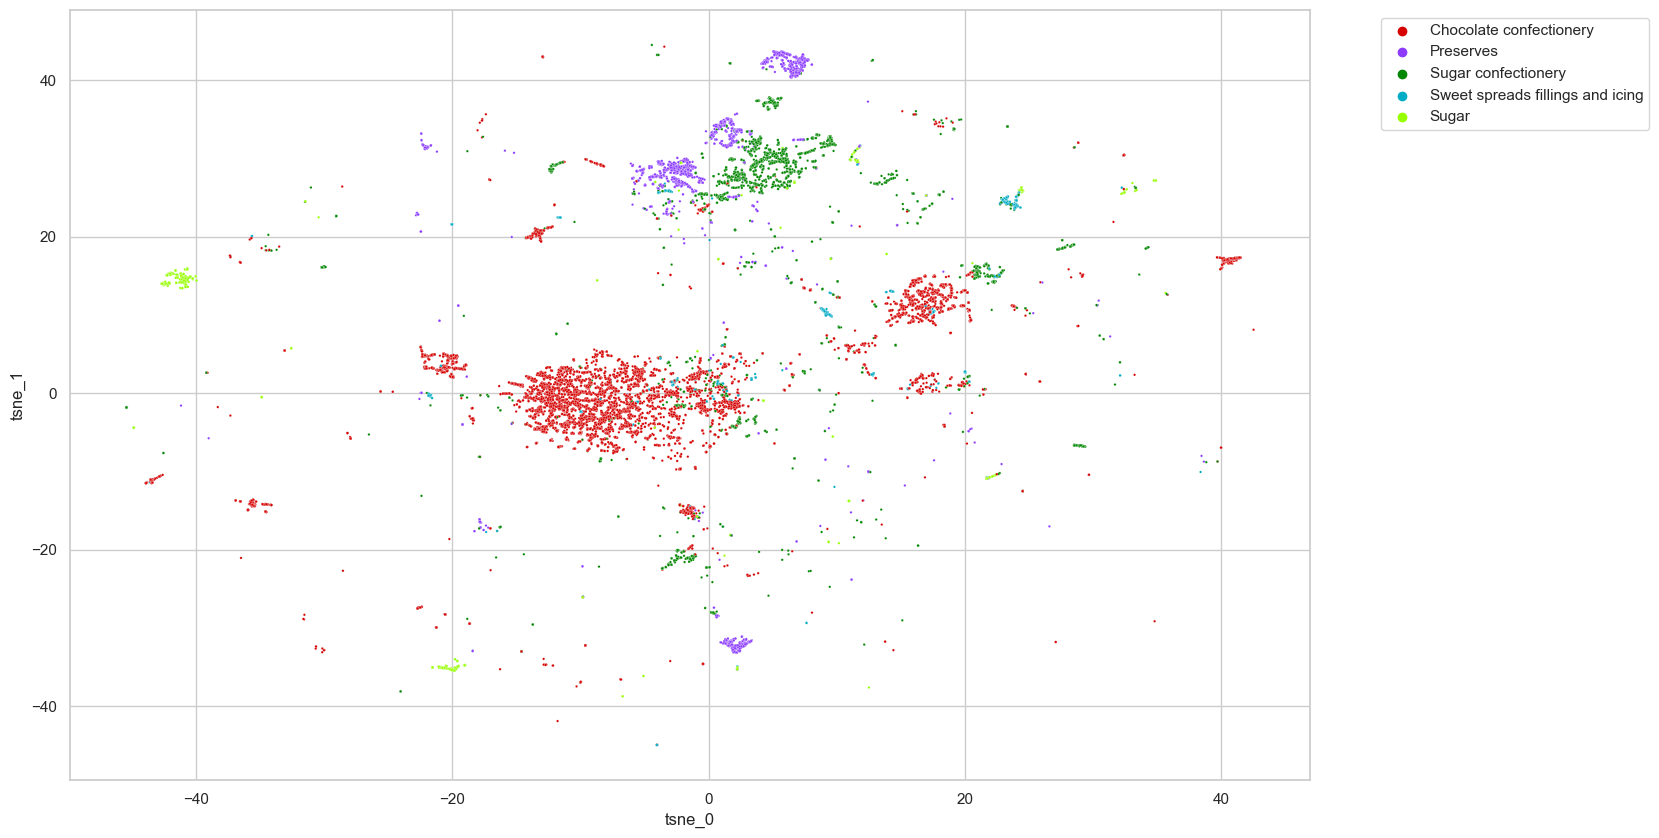

In [29]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pred['tsne_0'], y=pred['tsne_1'],
    hue=pred['subfoodgroup_pred'],
    palette=sns.color_palette(cc.glasbey, n_colors=pred['subfoodgroup_pred'].nunique()), s=3
)
plt.legend(bbox_to_anchor=(1.28, 1), loc='upper right')

In [30]:
# save level 2 cereal categories
pred.to_csv('../../future_of_food/NDNS UK/predictions/predictions_sugar_lev2_manuallabels_nonHI_RF_15Oct2024.csv', 
                      index=False)